## Rare Labels 

- Values present for a small percentage 

- Usually present less than 5% 

- Concept of cardinality 

## Rare label consequences 

- May add information in low cardinality 

- May add noise is high cardinality 


### Engineering Rare Labels 

- Replacing by most frequent label
- Grouping all rare labels together 

Categorical variables can have:

- One predominant category
- A small number of categories
- High cardinality



In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [276]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/FeatureEngineering/train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [277]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [278]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [279]:
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]

In [280]:
# get number of categories in variables 
categoricals = []
for col in data.columns:
    if data[col].dtypes =='O':
      print('{} categories : {} '.format(col, len(data[col].unique())))
      categoricals.append(col)

Sex categories : 2 
Ticket categories : 681 
Cabin categories : 148 
Embarked categories : 4 


In [281]:
# Get variables with more than n categories 
n = 8
cats = []
for col in data.columns:
    if data[col].dtypes =='O': 
        if len(data[col].unique())>n: 
            print('{} categories : {} '.format(col, len(data[col].unique())))
            cats.append(col)

Ticket categories : 681 
Cabin categories : 148 


In [282]:
for col in cats:
    if data[col].dtypes =='O': # if the variable is categorical
      print(100*data.groupby(col)[col].count()/np.float(len(data)))
      print()

Ticket
110152         0.336700
110413         0.336700
110465         0.224467
110564         0.112233
110813         0.112233
                 ...   
W./C. 6608     0.448934
W./C. 6609     0.112233
W.E.P. 5734    0.112233
W/C 14208      0.112233
WE/P 5735      0.224467
Name: Ticket, Length: 681, dtype: float64

Cabin
A10    0.112233
A14    0.112233
A16    0.112233
A19    0.112233
A20    0.112233
         ...   
F33    0.336700
F38    0.112233
F4     0.224467
G6     0.448934
T      0.112233
Name: Cabin, Length: 147, dtype: float64



In [283]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[cats], data['Survived'],
                                                    test_size=0.2)
X_train.shape, X_test.shape

((712, 2), (179, 2))

In [284]:
def label_encoder(X_train, X_test, columns, na_flag = False):
  import random
  for col in columns:
      mapper = {k:i for i, k in enumerate(X_train[col].unique(), 0)}
      if na_flag:
        mapper[np.nan] = np.nan
      X_train.loc[:, col] = X_train.loc[:, col].map(mapper)
      X_test.loc[:, col] = X_test.loc[:, col].map(mapper)
      X_test[col] = X_test[col].fillna(random.choice(list(mapper.values())))

In [285]:
label_encoder(X_train, X_test, cats)

In [286]:
X_train.isnull().sum()

Ticket    0
Cabin     0
dtype: int64

In [287]:
X_test.isnull().sum()

Ticket    0
Cabin     0
dtype: int64

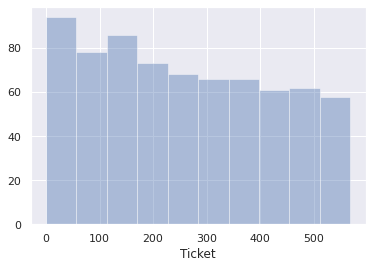

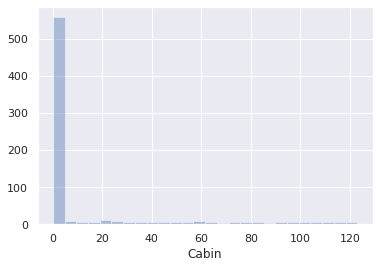

In [288]:
sns.set()
for i in cats:
  plt.figure()
  sns.distplot(X_train[i], kde=False)

In [289]:
def new_label_imputation(Xtrain, Xtest, threshold, cats):
  X_train, X_test = Xtrain.copy(), Xtest.copy()
  for col in cats:
      rows = len(X_train)
      temp_df = pd.Series(100*X_train[col].value_counts() / rows)
      nonrares = temp_df[temp_df>=threshold].index # non-rare labels
              
      X_train[col] = np.where(Xtrain[col].isin(nonrares), Xtrain[col], 'rare')
      X_test[col] = np.where(Xtest[col].isin(nonrares), Xtest[col], 'rare')
  return X_train, X_test


In [290]:
X_train_rare, X_test_rare = new_label_imputation(X_train, X_test, 1, cats)

In [291]:
label_encoder(X_train_rare, X_test_rare, cats)

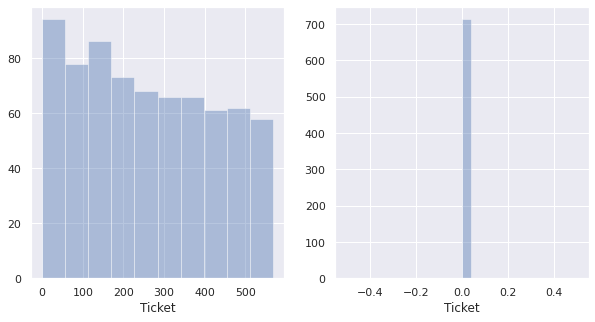

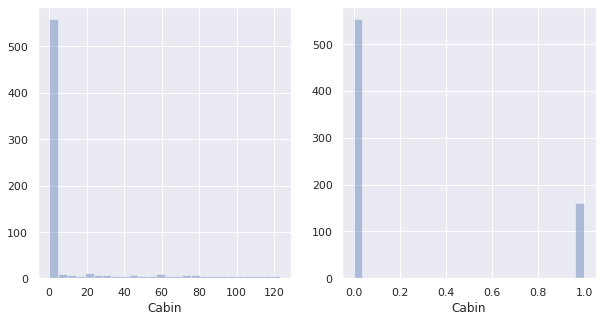

In [292]:
sns.set()
for i in cats:
  fig, ax = plt.subplots(1,2, figsize=(10,5))
  sns.distplot(X_train[i], kde=False, ax=ax[0])
  sns.distplot(X_train_rare[i], kde=False, ax=ax[1])

In [293]:
def frequent_imputation(Xtrain, Xtest, threshold, cats):
  X_train, X_test = Xtrain.copy(), Xtest.copy()
  for col in cats:
      rows = len(X_train)
      temp_df = pd.Series(100*X_train[col].value_counts() / rows)
      nonrares = temp_df[temp_df>=threshold].index # non-rare labels
      
      frequent_cat = X_train.groupby(col)[col].count().sort_values().tail(1).index.values[0]
        
      X_train[col] = np.where(Xtrain[col].isin(nonrares), Xtrain[col], frequent_cat)
      X_test[col] = np.where(Xtest[col].isin(nonrares), Xtest[col], frequent_cat)

  return X_train, X_test

In [294]:
X_train_freq, X_test_freq = frequent_imputation(X_train, X_test, 1, cats)

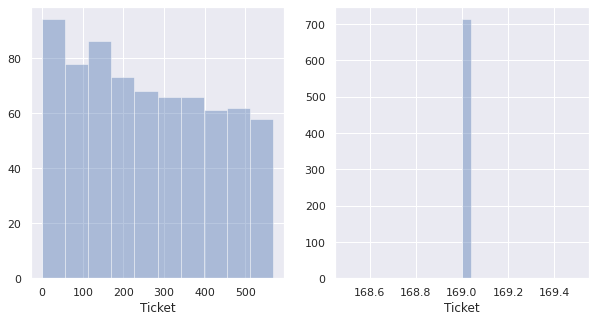

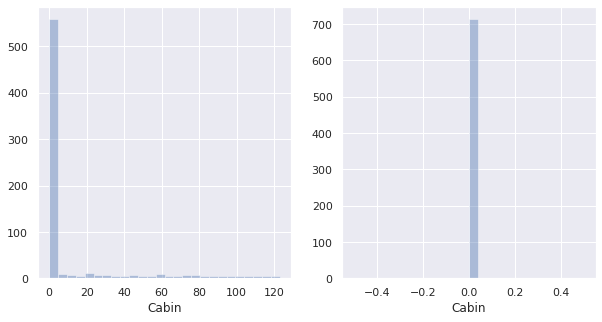

In [295]:
sns.set()
for i in cats:
  fig, ax = plt.subplots(1,2, figsize=(10,5))
  sns.distplot(X_train[i], kde=False, ax=ax[0])
  sns.distplot(X_train_freq[i], kde=False, ax=ax[1])

In [296]:
def classifier(X_train, y_train, X_test, y_test, cols, model):
  from sklearn.metrics import accuracy_score
  model.fit(X_train[cols],y_train)
  y_pred = model.predict(X_test[cols])
  y_pred = np.round(y_pred).flatten()
  print(accuracy_score(y_test, y_pred))

In [297]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
classifier(X_train_rare, y_train, X_test_rare, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.4134078212290503
0.5865921787709497


In [298]:
from sklearn.linear_model import RidgeClassifier
model = RidgeClassifier()
classifier(X_train_rare, y_train, X_test_rare, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.4134078212290503
0.5865921787709497


In [299]:
from sklearn.linear_model import RidgeClassifierCV
model = RidgeClassifierCV()
classifier(X_train_rare, y_train, X_test_rare, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.4134078212290503
0.5865921787709497


In [300]:
from sklearn.svm import SVC
model = SVC()
classifier(X_train_rare, y_train, X_test_rare, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.4134078212290503
0.5865921787709497


In [301]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
classifier(X_train, y_train, X_test, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.6480446927374302
0.5865921787709497


In [302]:
from sklearn.svm import LinearSVC
model = LinearSVC()
classifier(X_train, y_train, X_test, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.4245810055865922
0.4134078212290503


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [303]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
classifier(X_train, y_train, X_test, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.6871508379888268
0.5865921787709497


In [304]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
classifier(X_train, y_train, X_test, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.6871508379888268
0.5865921787709497


In [305]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
classifier(X_train, y_train, X_test, y_test, cats, model)
classifier(X_train_freq, y_train, X_test_freq, y_test, cats, model)

0.5865921787709497
0.5865921787709497
